In [1]:
import numpy as np
import os,sys
sys.path.append("..")
from matplotlib import pyplot as plt
%matplotlib inline

from config import from_data


In [2]:
sig_folders = [from_data("sig56/")]

decay_df_paths = [from_data("decays/KS_decays_5.csv"),
                  from_data("decays/KS_decays_6.csv")]

output_df_name = from_data("decays/far_ks_counts_56.csv")

In [3]:
filenames = [fn  for sig_folder in sig_folders for fn in os.listdir(sig_folder) if fn.endswith(".hits.csv")]

In [4]:
id_tuples = map(lambda s: map(int,s.split('.')[0].split('_')),filenames)

runIDs, eventIDs = zip(*id_tuples)

### read decays

In [5]:
#auxilary functions to preprocess decay data
import pandas as pd
def decayQuality(decayString):
    '''how orthodoxal KS is [lower = better]'''
    particle_codes = decayString.split('&')
    piplus_count = particle_codes.count('211')
    piminus_count = particle_codes.count('-211')
    
    if piplus_count ==0 and piminus_count ==0: return float('inf')
    
    return len(particle_codes) - piplus_count - piminus_count
def preprocess_decay_data(df_path,
                          min_decay_z = 0,
                          max_quality = 10,
                          max_origin_distance=25000,
                          min_flight_distance = 0,
                          ):
    """load KS decay dataframe generated by /preprocess/KS_extractor.py 
    and filter out irrelevant decays (e.g. Ks->2pi0)"""
    
    print "reading",df_path

    
    decay_df = pd.DataFrame.from_csv(df_path,index_col=None,sep=';')
    decay_df.children = decay_df.children.astype(np.string_)

    print len(np.unique( (decay_df.runID,decay_df.eventID))),'events in dataframe'


    decay_df["originDistanceZ"] = (decay_df.originZ - decay_df.primaryZ)
    
    decay_df["decayQuality"] = map(decayQuality,decay_df.children)
    
    decay_vectors = decay_df[["decayX","decayY","decayZ"]].values
    origin_vectors = decay_df[["originX","originY","originZ"]].values
    decay_df["flightDistance"] = np.linalg.norm(decay_vectors-origin_vectors,axis=1)
    
    
    isGood = np.logical_and.reduce([
        decay_df.decayQuality <=max_quality,
        decay_df.originDistanceZ.abs() <= max_origin_distance,
        decay_df.flightDistance >= min_flight_distance,
        decay_df.decayZ >= min_decay_z
    ])
    good_decay_df = decay_df[isGood]
    print len(np.unique( (good_decay_df.runID,good_decay_df.eventID))),'events left with relevant decays'
    return good_decay_df

In [6]:
decay_dataframe_shards = map(preprocess_decay_data,decay_df_paths)

decays = pd.concat(decay_dataframe_shards)

print len(decays),'relevant decays total in all dataframes'
print 'grouping...'

#function (runID(int),eventID(int)) -> decays for this pair(df)
decay_groups = decays.groupby(["runID","eventID"],as_index=True)

#strip unused columns
decay_groups = decay_groups[[u'decayX',u'decayY',u'decayZ',u'children',u'flightDistance']]

#e.g. decay_groups.get_group((3695761 ,485762))
print 'done'

reading /srv/hd7/jheuristic/ksfinder_data/decays/KS_decays_5.csv
17573 events in dataframe
17545 events left with relevant decays
reading /srv/hd7/jheuristic/ksfinder_data/decays/KS_decays_6.csv
17664 events in dataframe
17644 events left with relevant decays
307310 relevant decays total in all dataframes
grouping...
done


# Decay maps

In [19]:
from lib.percentile_grid import PercentileSpaceMapper1D
#on what PercentileSpaceMapper does, see percentile-mapper-tests.ipynb

xmapper = PercentileSpaceMapper1D(decays.decayX,n_centers=50,smoothing=3.)
ymapper = PercentileSpaceMapper1D(decays.decayY,n_centers=50,smoothing=3.)
zmapper = PercentileSpaceMapper1D(decays.decayZ,n_centers=50,smoothing=3.)


# Aggregation

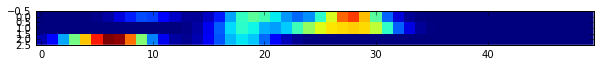

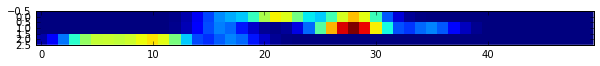

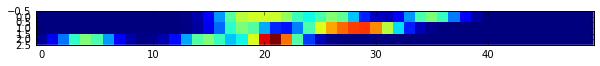

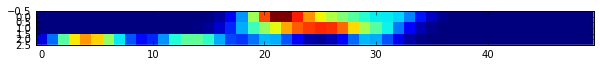

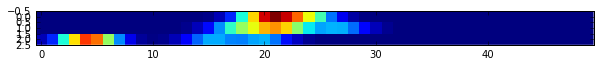

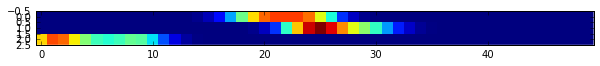

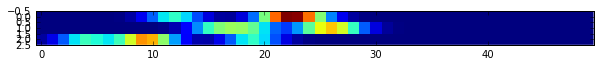

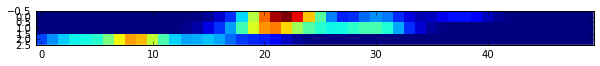

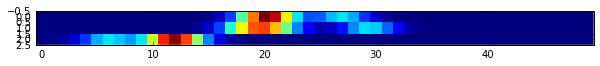

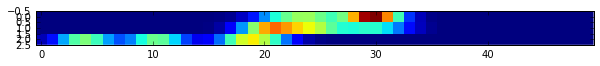

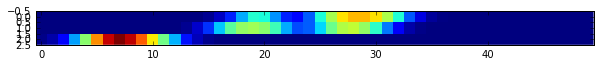

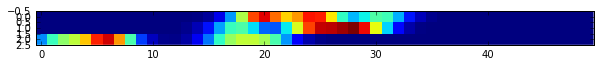

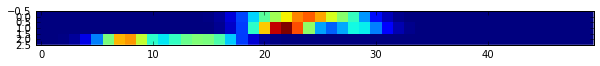

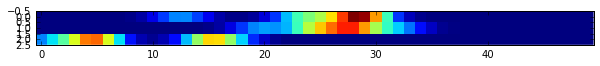

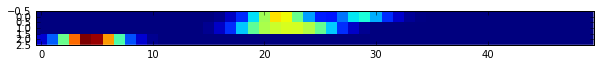

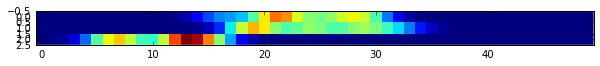

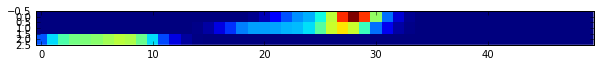

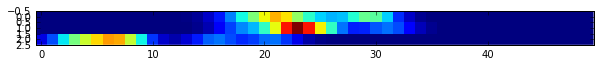

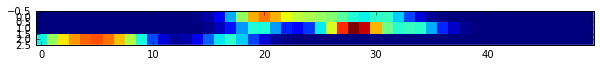

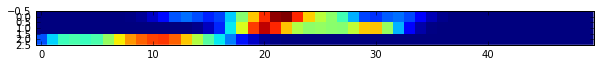

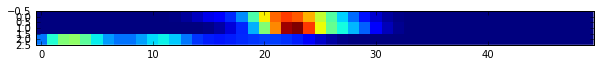

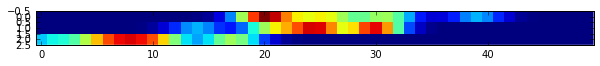

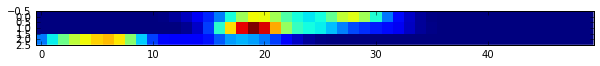

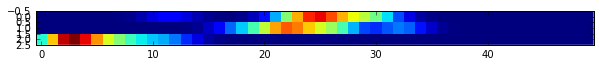

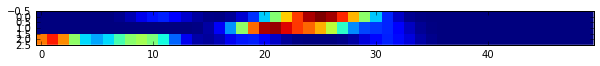

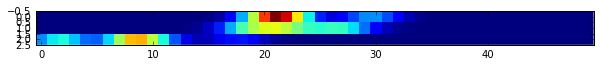

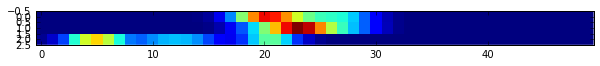

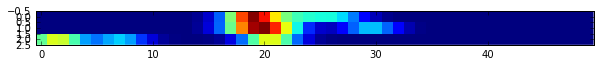

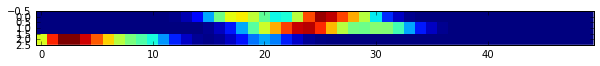

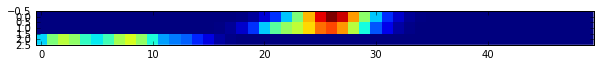

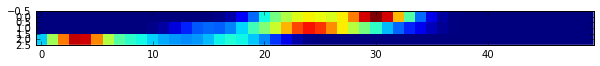

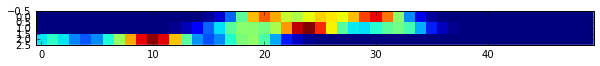

In [ ]:
%%time

#aligning images with decays
# sorry i'm just too lazy to implement joblib parallelism here, 
# even so, it takes a single tea cup to process 30k events


#runIDs,eventIDs are left from retina image preprocessing phase

X_list = []
y_list = []
y_target = []
y_decays = []
for i,(runID,eventID,fname) in enumerate(zip(runIDs,eventIDs,filenames)):
    X_list.append(fname.split('.')[0]) 
        
    if (runID,eventID) not in decay_groups.groups:
        y_list.append(None)
        y_target.append(0)
    else:
        event_decays=decay_groups.get_group((runID,eventID))
        y_list.append(event_decays)
        y_target.append(len(event_decays))

        
        xmap = xmapper.get_activity_percentile(event_decays.decayX.values)
        ymap = ymapper.get_activity_percentile(event_decays.decayY.values)
        zmap = zmapper.get_activity_percentile(event_decays.decayZ.values)

        y_decays.append(np.vstack([xmap,ymap,zmap]))

        if i%1000==0:

            plt.figure(figsize = [10,3])
            plt.imshow(np.vstack([xmap,ymap,zmap]),interpolation='none')
            plt.show()

        
    


In [13]:
ref_df = pd.DataFrame({"X_filename":X_list,"relevant_decay_count":y_target})

In [14]:
ref_df.to_csv(output_df_name,index=None)

In [15]:
(ref_df.relevant_decay_count>0).mean()

0.99864370426444615